Importing the Libraries and Datset(PNR_flight_level_data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
filepath = "/content/drive/MyDrive/United Airlines/PNR+Flight+Level+Data.csv"

In [3]:
data = pd.read_csv(filepath)

In [4]:
data.head(5)

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,record_locator,pnr_creation_date,total_pax,is_child,basic_economy_ind,is_stroller_user,lap_child_count
0,UA,2494,2025-08-04,ORD,MCI,PNR_520583,2025-07-07,1,N,0,N,0
1,UA,2483,2025-08-06,ORD,IAH,PNR_296107,2025-03-28,1,N,0,N,0
2,UA,1620,2025-08-01,ORD,SEA,PNR_296108,2025-06-30,4,Y,0,N,0
3,UA,1620,2025-08-01,ORD,SEA,PNR_296108,2025-06-30,4,N,0,N,1
4,UA,1620,2025-08-01,ORD,SEA,PNR_296108,2025-06-30,4,Y,0,Y,0


In [5]:
data.shape

(687878, 12)

Performing Some Basic Feature Engineering And Checking for missing Values, Duplicated etc

In [6]:
data['is_child'] = data['is_child'].map({'Y': 1, 'N': 0})
data['is_stroller_user'] = data['is_stroller_user'].map({'Y': 1, 'N': 0})

In [7]:
data.isnull().sum()

,0
company_id,0
flight_number,0
scheduled_departure_date_local,0
scheduled_departure_station_code,0
scheduled_arrival_station_code,0
record_locator,0
pnr_creation_date,0
total_pax,0
is_child,0
basic_economy_ind,0


In [8]:
data.duplicated().sum()

np.int64(0)

# Calculating Passenger-Level Summary

1. **Convert to numeric:** Ensured all relevant columns (`total_pax`, `lap_child_count`, `is_child`, `basic_economy_ind`, `is_stroller_user`) are numeric to handle any bad data.  
2. **Aggregate per flight:** Combined passenger data for each flight using a 5-column unique identifier (`company_id`, `flight_number`, `scheduled_departure_date_local`, `scheduled_departure_station_code`, `scheduled_arrival_station_code`). This gives totals like:
   - Total passengers
   - Total lap children
   - Total children
   - Total basic economy passengers
   - Total stroller users
3. **Handle missing values:** Replaced any `NaN` values with 0 to avoid errors in calculations.  
4. **Derived ratios:** Calculated important passenger-related ratios to quantify complexity:
   - **Child ratio:** Fraction of children (including lap children) in the flight.
   - **Basic economy ratio:** Fraction of passengers in basic economy.
   - **Stroller ratio:** Fraction of passengers using strollers.


In [9]:
# Convert relevant columns to numeric (bad data -> NaN)
numeric_cols = ['total_pax', 'lap_child_count', 'is_child', 'basic_economy_ind', 'is_stroller_user']
for col in numeric_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Aggregate per flight using 5-column unique flight identifier
flight_passenger_summary = data.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local',
     'scheduled_departure_station_code', 'scheduled_arrival_station_code']
).agg(
    total_pax=('total_pax', 'sum'),
    total_lap_children=('lap_child_count', 'sum'),
    total_children=('is_child', 'sum'),
    total_basic_economy=('basic_economy_ind', 'sum'),
    total_stroller_users=('is_stroller_user', 'sum')
).reset_index()

# Replace any NaN sums with 0 (just in case)
flight_passenger_summary.fillna(0, inplace=True)

# Derived ratios (avoid divide by zero)
flight_passenger_summary['child_ratio'] = flight_passenger_summary.apply(
    lambda x: (x['total_lap_children'] + x['total_children']) / x['total_pax']
    if x['total_pax'] > 0 else 0, axis=1
)

flight_passenger_summary['basic_economy_ratio'] = flight_passenger_summary.apply(
    lambda x: x['total_basic_economy'] / x['total_pax'] if x['total_pax'] > 0 else 0, axis=1
)

flight_passenger_summary['stroller_ratio'] = flight_passenger_summary.apply(
    lambda x: x['total_stroller_users'] / x['total_pax'] if x['total_pax'] > 0 else 0, axis=1
)



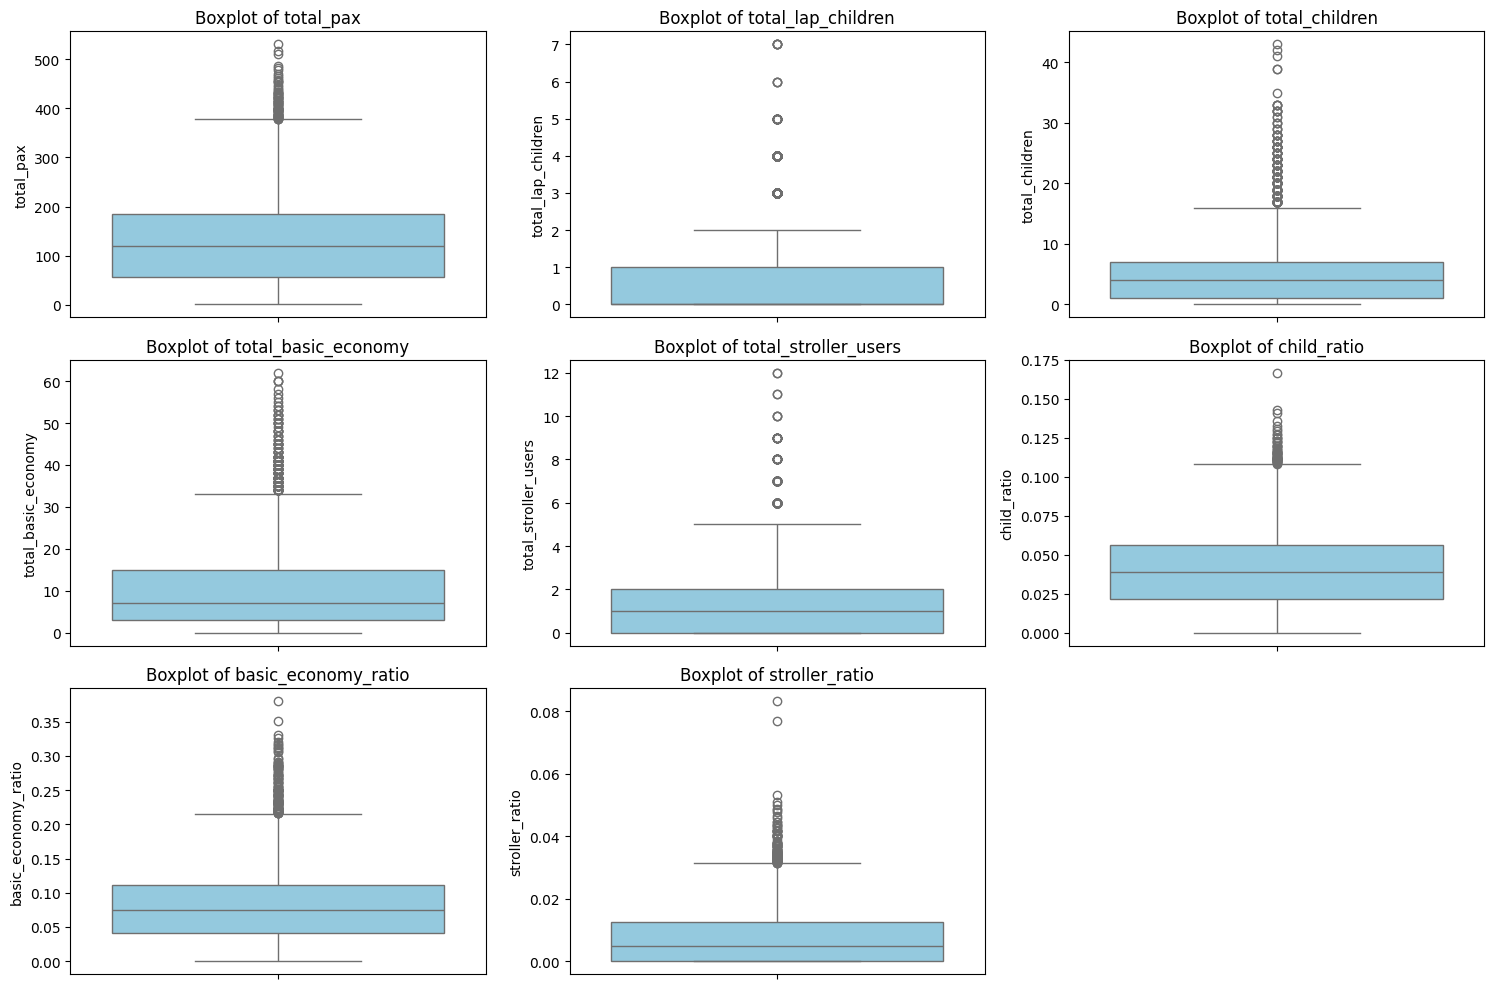

In [10]:
# Select numeric columns for outlier check
cols_to_check = [
    'total_pax', 'total_lap_children', 'total_children',
    'total_basic_economy', 'total_stroller_users',
    'child_ratio', 'basic_economy_ratio', 'stroller_ratio'
]

plt.figure(figsize=(15, 10))

for i, col in enumerate(cols_to_check, 1):
    plt.subplot(3, 3, i)  # 3 rows, 3 cols grid
    sns.boxplot(y=flight_passenger_summary[col], color="skyblue")
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

# Analysing and Visualizing Data

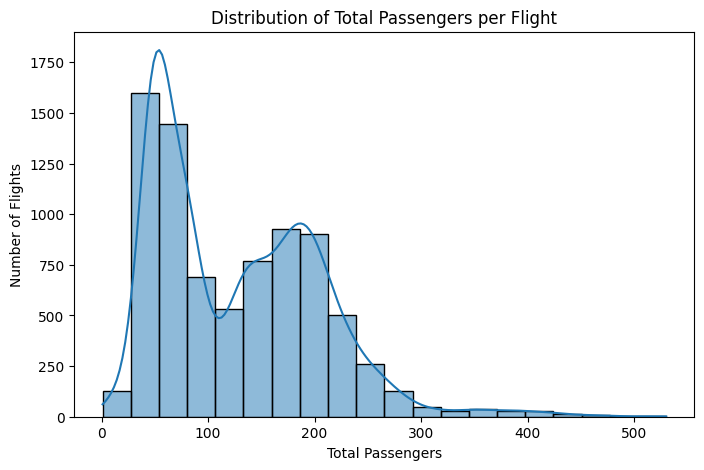

In [11]:
plt.figure(figsize=(8,5))
sns.histplot(flight_passenger_summary['total_pax'], bins=20, kde=True)
plt.title('Distribution of Total Passengers per Flight')
plt.xlabel('Total Passengers')
plt.ylabel('Number of Flights')
plt.show()


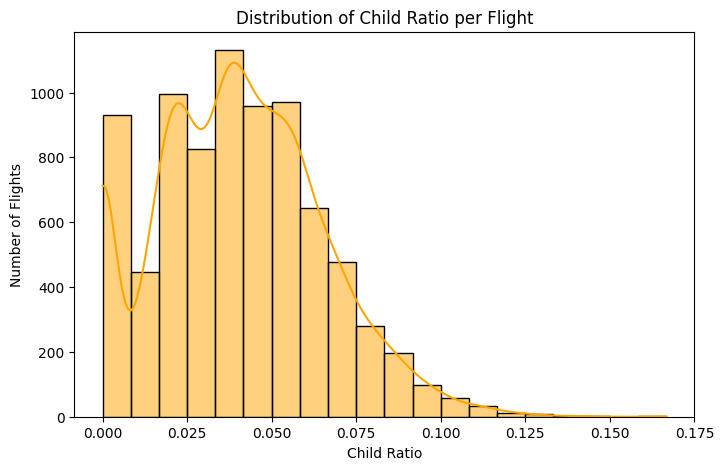

In [12]:
plt.figure(figsize=(8,5))
sns.histplot(flight_passenger_summary['child_ratio'], bins=20, kde=True, color='orange')
plt.title('Distribution of Child Ratio per Flight')
plt.xlabel('Child Ratio')
plt.ylabel('Number of Flights')
plt.show()


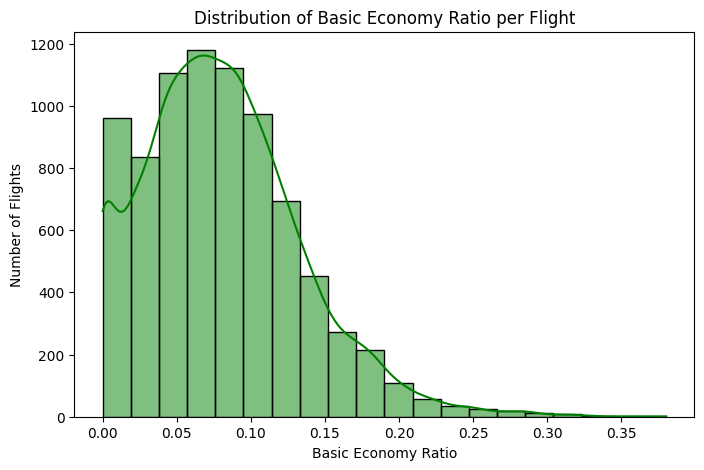

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(flight_passenger_summary['basic_economy_ratio'], bins=20, kde=True, color='green')
plt.title('Distribution of Basic Economy Ratio per Flight')
plt.xlabel('Basic Economy Ratio')
plt.ylabel('Number of Flights')
plt.show()

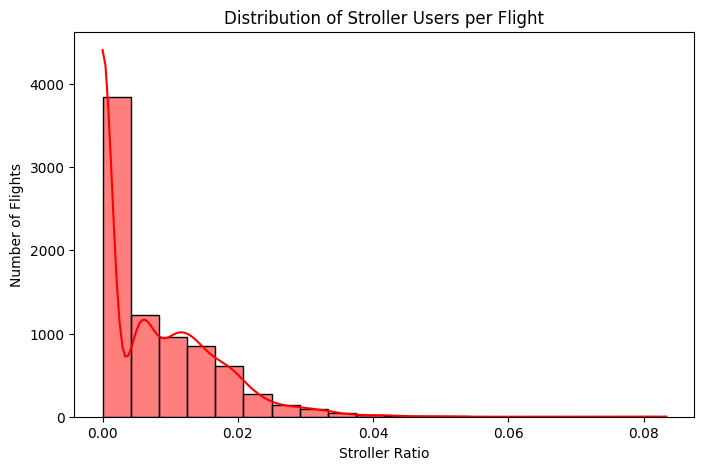

In [14]:
plt.figure(figsize=(8,5))
sns.histplot(flight_passenger_summary['stroller_ratio'], bins=20, kde=True, color='red')
plt.title('Distribution of Stroller Users per Flight')
plt.xlabel('Stroller Ratio')
plt.ylabel('Number of Flights')
plt.show()


# Calculating Passenger Complexity Score

**What it is:**  
Passenger complexity score quantifies how challenging it is to manage passengers on a flight based on total passengers, children, basic economy passengers, and stroller users.

**What we did:**  
1. **Selected features:** Used total passengers and the ratios of children, basic economy, and stroller users.  
2. **Prepared for scaling:** Ensured numeric values, handled missing or extreme values.  
3. **Scaled features:** Normalized all selected features to a 0-1 range using Min-Max scaling.  
4. **Weighted sum:** Combined scaled features into a single **Passenger Complexity Score** using weights:
   - Total passengers → 25%
   - Child ratio → 35%
   - Basic economy ratio → 25%
   - Stroller ratio → 15%

**Why it matters:**  
This score helps identify flights that are more difficult from a passenger management perspective, highlighting which flights may require more resources or attention.


In [15]:
#Features to include in passenger complexity
# We'll use ratios and total passengers
flight_passenger_summary['total_pax_score'] = flight_passenger_summary['total_pax']  # larger number = more complexity
flight_passenger_summary['child_ratio_score'] = flight_passenger_summary['child_ratio']
flight_passenger_summary['basic_economy_ratio_score'] = flight_passenger_summary['basic_economy_ratio']
flight_passenger_summary['stroller_ratio_score'] = flight_passenger_summary['stroller_ratio']

# Prepare for scaling
columns_to_scale = ['total_pax_score', 'child_ratio_score', 'basic_economy_ratio_score', 'stroller_ratio_score']

# Ensure numeric and handle missing values
for col in columns_to_scale:
    flight_passenger_summary[col] = pd.to_numeric(flight_passenger_summary[col], errors='coerce')
    flight_passenger_summary[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    flight_passenger_summary[col].fillna(flight_passenger_summary[col].median(), inplace=True)

# Scale features 0-1
scaler = MinMaxScaler()
flight_passenger_summary[columns_to_scale] = scaler.fit_transform(flight_passenger_summary[columns_to_scale])

# Weighted sum to calculate Passenger Complexity
weights = {
    'total_pax_score': 0.25,
    'child_ratio_score': 0.35,
    'basic_economy_ratio_score': 0.25,
    'stroller_ratio_score': 0.15
}

flight_passenger_summary['passenger_complexity_score'] = sum(
    flight_passenger_summary[col] * w for col, w in weights.items()
)


/tmp/ipython-input-903862889.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  flight_passenger_summary[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipython-input-903862889.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [16]:
flight_passenger_summary[['company_id', 'flight_number', 'scheduled_departure_date_local',
                               'scheduled_departure_station_code', 'scheduled_arrival_station_code',
                               'passenger_complexity_score']].head()

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,passenger_complexity_score
0,G7,4173,2025-08-01,ORD,AVL,0.124466
1,G7,4173,2025-08-03,ORD,AVL,0.171413
2,G7,4173,2025-08-04,ORD,AVL,0.022212
3,G7,4173,2025-08-05,ORD,AVL,0.124072
4,G7,4173,2025-08-06,ORD,AVL,0.035259


In [17]:
flight_passenger_summary.to_csv('flight_passenger_summary.csv', index=False)
